# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [56]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna
HopsworksSettings initialized!


In [57]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util_2
import os

In [58]:
today = datetime.datetime.now()

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [59]:
import json

project = hopsworks.login(engine="python")
fs = project.get_feature_store()

secrets = hopsworks.get_secrets_api()

AQICN_API_KEY = secrets.get_secret("AQICN_API_KEY").value

sensors_str = secrets.get_secret("SENSORS_MADRID_JSON").value
SENSORS = json.loads(sensors_str) 

today = datetime.date.today()


2025-11-16 22:18:10,573 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 22:18:10,578 INFO: Initializing external client
2025-11-16 22:18:10,578 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 22:18:11,181 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-16 22:18:12,062 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271984


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [60]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=5,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-16 22:18:15,721 INFO: There is no parent information


Downloading: 0.000%|          | 0/350857 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/97921 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/96492 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/92941 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/94089 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/93959 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/92795 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/97291 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/91736 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/25079 elapsed<00:00 remaining<?

In [61]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
#retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor(
    subsample=0.7,
    reg_lambda=5.0,
    reg_alpha=0.3,
    n_estimators=300,
    min_child_weight=1,
    max_depth=3,
    learning_rate=0.03,
    gamma=0.0,
    colsample_bytree=0.9,
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist"
)
retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.981061E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [62]:
weather_fg = fs.get_feature_group(
    name="weather_madrid_sensors",
    version=1,
)

batch_data = (
    weather_fg
    .filter(weather_fg.date >= today)
    .read()
)

feature_cols = [
    "temperature_2m_mean",
    "precipitation_sum",
    "wind_speed_10m_max",
    "wind_direction_10m_dominant",
    "cloud_cover_max",
    "relative_humidity_2m_mean",
    "dew_point_2m_max",
]




Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.05s) 


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [63]:
X_batch = batch_data[feature_cols].values  
batch_data["predicted_pm25"] = retrieved_xgboost_model.predict(X_batch
)
batch_data.sort_values("date", inplace=True)
batch_data


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,cloud_cover_max,relative_humidity_2m_mean,dew_point_2m_max,city,sensor_id,country,street,predicted_pm25
0,2025-11-17 00:00:00+00:00,12.65,0.0,5.351785,42.273628,48.0,69.0,7.109425,madrid,mendez_alvaro,spain,mendez-alvaro,52.258221
33,2025-11-17 00:00:00+00:00,11.70,0.0,5.351785,42.273628,48.0,69.0,6.200077,madrid,plaza_castilla,spain,plaza-de-castilla,52.808750
40,2025-11-17 00:00:00+00:00,12.05,0.0,5.351785,42.273628,48.0,69.0,6.535117,madrid,escuelas_aguirre,spain,escuelas-aguirre,52.607952
21,2025-11-17 00:00:00+00:00,12.35,0.0,5.351785,42.273628,48.0,69.0,6.822279,madrid,casa_de_campo,spain,casa-de-campo,52.607952
25,2025-11-17 00:00:00+00:00,12.00,0.0,5.351785,42.273628,48.0,69.0,6.487256,madrid,cuatro_caminos,spain,cuatro-caminos,52.808750
5,2025-11-17 00:00:00+00:00,12.05,0.0,5.351785,42.273628,48.0,69.0,6.535117,madrid,castellana,spain,castellana,52.607952
10,2025-11-17 00:00:00+00:00,12.45,0.0,5.351785,42.273628,48.0,69.0,6.917996,madrid,fernandez_ladreda,spain,fernandez-ladreda,52.607952
27,2025-11-18 00:00:00+00:00,11.30,0.0,5.623380,230.194473,0.0,62.0,4.280153,madrid,mendez_alvaro,spain,mendez-alvaro,51.871143
9,2025-11-18 00:00:00+00:00,10.65,0.0,5.623380,230.194473,0.0,62.0,3.665493,madrid,cuatro_caminos,spain,cuatro-caminos,51.913567
8,2025-11-18 00:00:00+00:00,11.00,0.0,5.623380,230.194473,0.0,62.0,3.996475,madrid,casa_de_campo,spain,casa-de-campo,51.921047


In [64]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 0 to 17
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         42 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          42 non-null     float32                
 2   precipitation_sum            42 non-null     float32                
 3   wind_speed_10m_max           42 non-null     float32                
 4   wind_direction_10m_dominant  42 non-null     float32                
 5   cloud_cover_max              42 non-null     float32                
 6   relative_humidity_2m_mean    42 non-null     float32                
 7   dew_point_2m_max             42 non-null     float32                
 8   city                         42 non-null     object                 
 9   sensor_id                    42 non-null     object                 
 10  country  

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [80]:
# 2) Sacamos las fechas distintas en orden (sin hora)
unique_dates = batch_data['date'].dt.date.drop_duplicates().sort_values()

# 3) Creamos un mapa: fecha -> día_antes_del_forecast (1,2,3,...)
date_to_day = {d: i + 1 for i, d in enumerate(unique_dates)}

# 4) Asignamos la columna usando ese mapa
batch_data['days_before_forecast_day'] = batch_data['date'].dt.date.map(date_to_day)

batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,cloud_cover_max,relative_humidity_2m_mean,dew_point_2m_max,city,sensor_id,country,street,predicted_pm25,days_before_forecast_day
0,2025-11-17 00:00:00+00:00,12.65,0.0,5.351785,42.273628,48.0,69.0,7.109425,madrid,mendez_alvaro,spain,mendez-alvaro,52.258221,1
33,2025-11-17 00:00:00+00:00,11.70,0.0,5.351785,42.273628,48.0,69.0,6.200077,madrid,plaza_castilla,spain,plaza-de-castilla,52.808750,1
40,2025-11-17 00:00:00+00:00,12.05,0.0,5.351785,42.273628,48.0,69.0,6.535117,madrid,escuelas_aguirre,spain,escuelas-aguirre,52.607952,1
21,2025-11-17 00:00:00+00:00,12.35,0.0,5.351785,42.273628,48.0,69.0,6.822279,madrid,casa_de_campo,spain,casa-de-campo,52.607952,1
25,2025-11-17 00:00:00+00:00,12.00,0.0,5.351785,42.273628,48.0,69.0,6.487256,madrid,cuatro_caminos,spain,cuatro-caminos,52.808750,1
5,2025-11-17 00:00:00+00:00,12.05,0.0,5.351785,42.273628,48.0,69.0,6.535117,madrid,castellana,spain,castellana,52.607952,1
10,2025-11-17 00:00:00+00:00,12.45,0.0,5.351785,42.273628,48.0,69.0,6.917996,madrid,fernandez_ladreda,spain,fernandez-ladreda,52.607952,1
7,2025-11-18 00:00:00+00:00,11.10,0.0,5.623380,230.194473,0.0,62.0,4.091036,madrid,fernandez_ladreda,spain,fernandez-ladreda,51.871143,2
27,2025-11-18 00:00:00+00:00,11.30,0.0,5.623380,230.194473,0.0,62.0,4.280153,madrid,mendez_alvaro,spain,mendez-alvaro,51.871143,2
8,2025-11-18 00:00:00+00:00,11.00,0.0,5.623380,230.194473,0.0,62.0,3.996475,madrid,casa_de_campo,spain,casa-de-campo,51.921047,2


In [81]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 0 to 17
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         42 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          42 non-null     float32                
 2   precipitation_sum            42 non-null     float32                
 3   wind_speed_10m_max           42 non-null     float32                
 4   wind_direction_10m_dominant  42 non-null     float32                
 5   cloud_cover_max              42 non-null     float32                
 6   relative_humidity_2m_mean    42 non-null     float32                
 7   dew_point_2m_max             42 non-null     float32                
 8   city                         42 non-null     object                 
 9   sensor_id                    42 non-null     object                 
 10  country  

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

Generando gráfica para mendez-alvaro → /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna/docs/air-quality/assets/img/pm25_forecast_mendez-alvaro.png


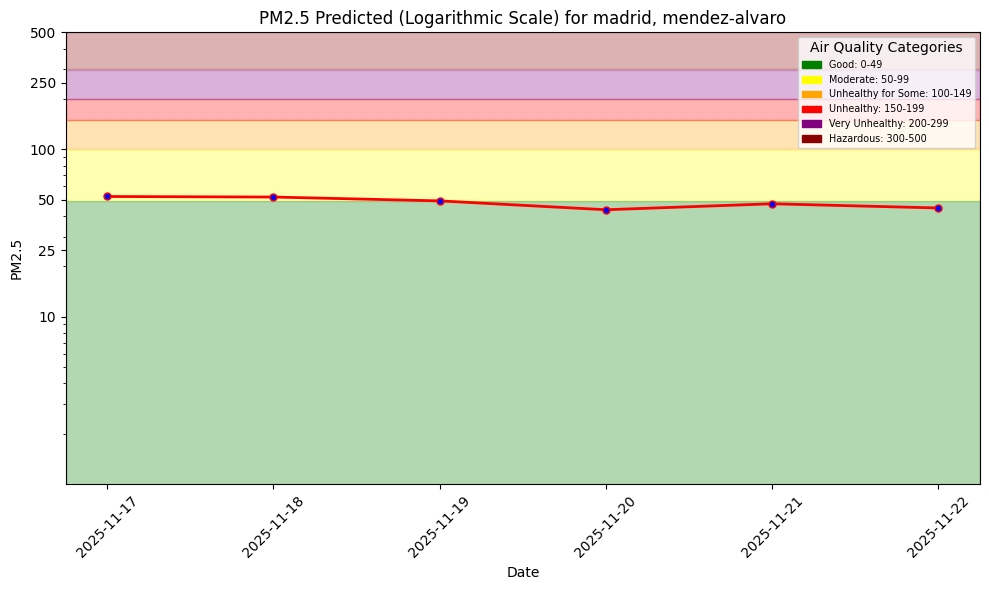

Generando gráfica para plaza-de-castilla → /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna/docs/air-quality/assets/img/pm25_forecast_plaza-de-castilla.png


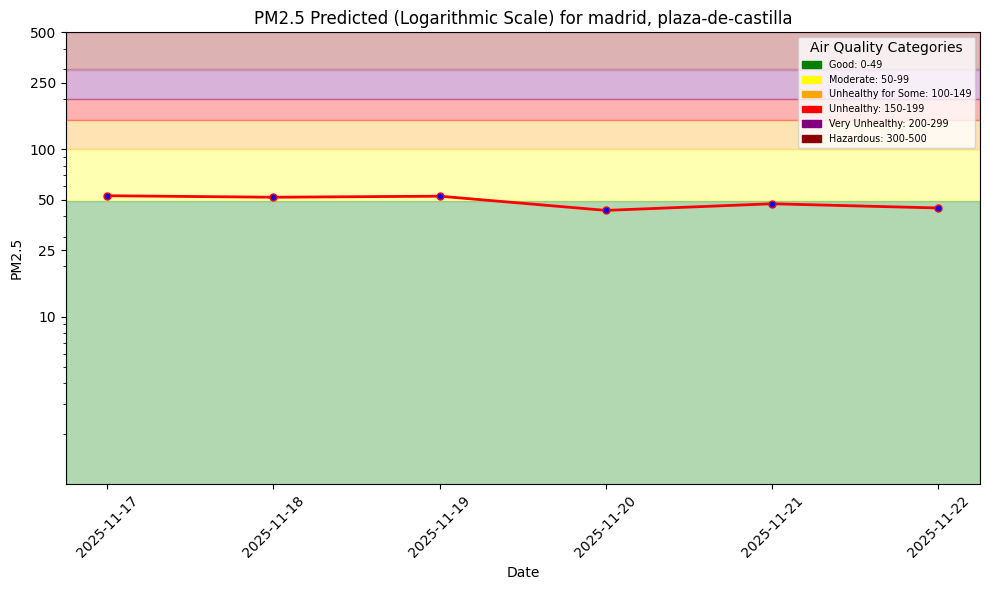

Generando gráfica para escuelas-aguirre → /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna/docs/air-quality/assets/img/pm25_forecast_escuelas-aguirre.png


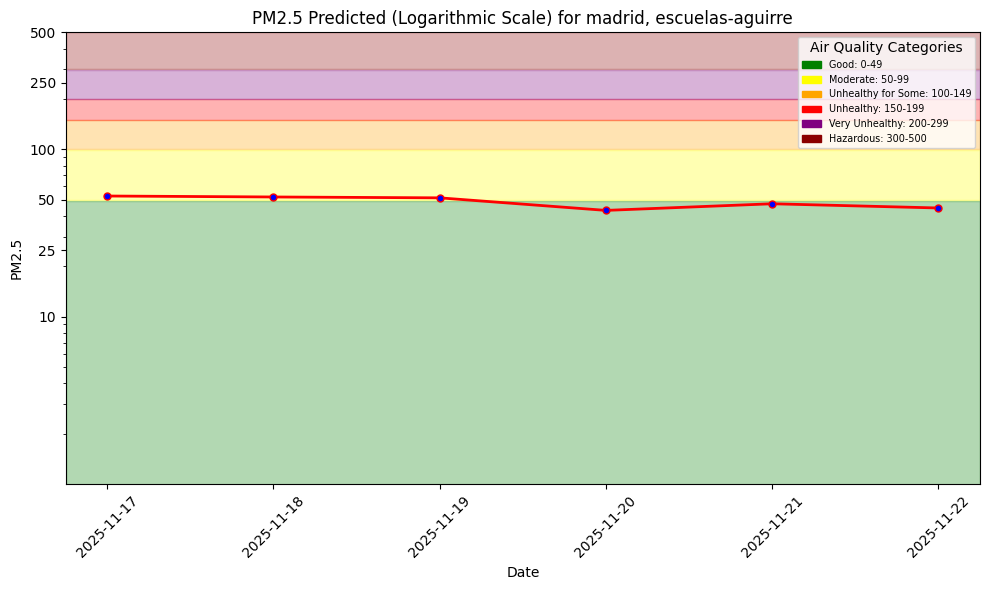

Generando gráfica para casa-de-campo → /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna/docs/air-quality/assets/img/pm25_forecast_casa-de-campo.png


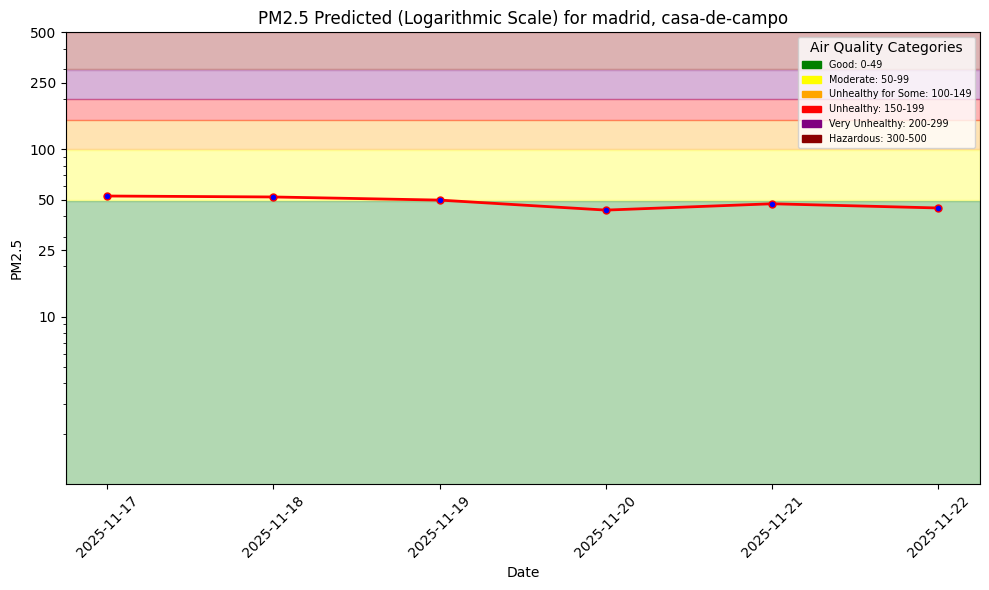

Generando gráfica para cuatro-caminos → /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna/docs/air-quality/assets/img/pm25_forecast_cuatro-caminos.png


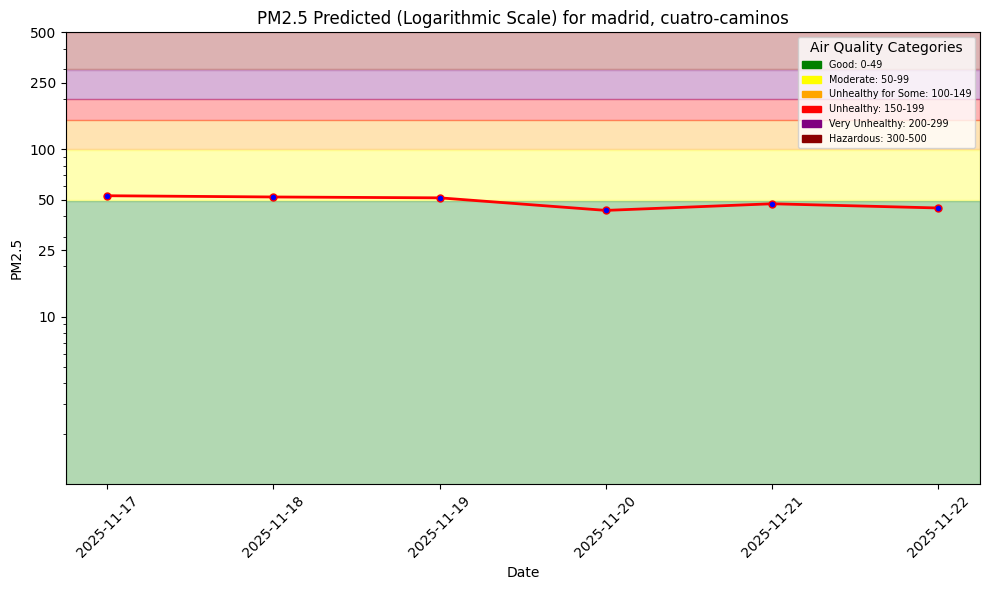

Generando gráfica para castellana → /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna/docs/air-quality/assets/img/pm25_forecast_castellana.png


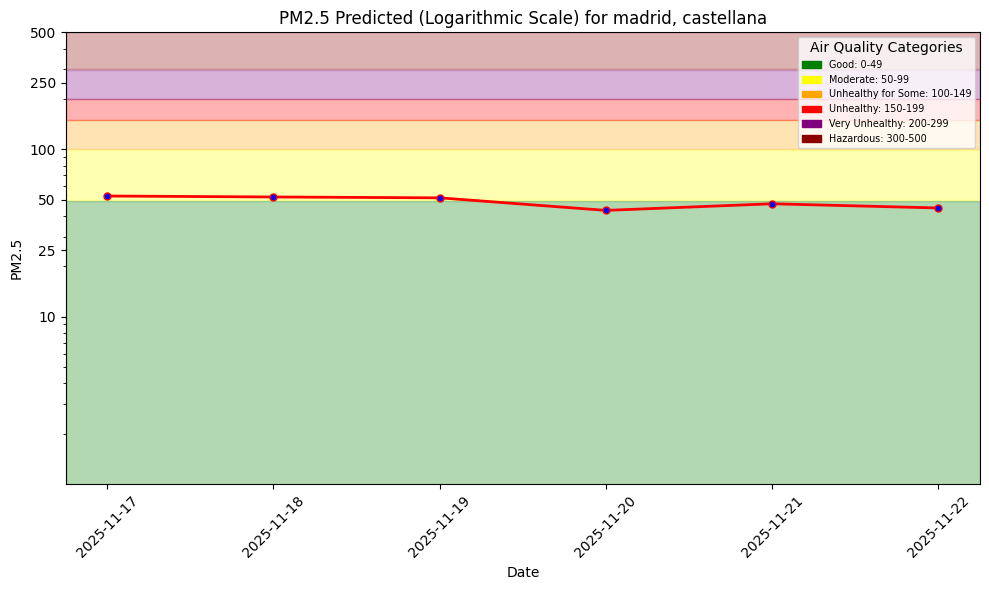

Generando gráfica para fernandez-ladreda → /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna/docs/air-quality/assets/img/pm25_forecast_fernandez-ladreda.png


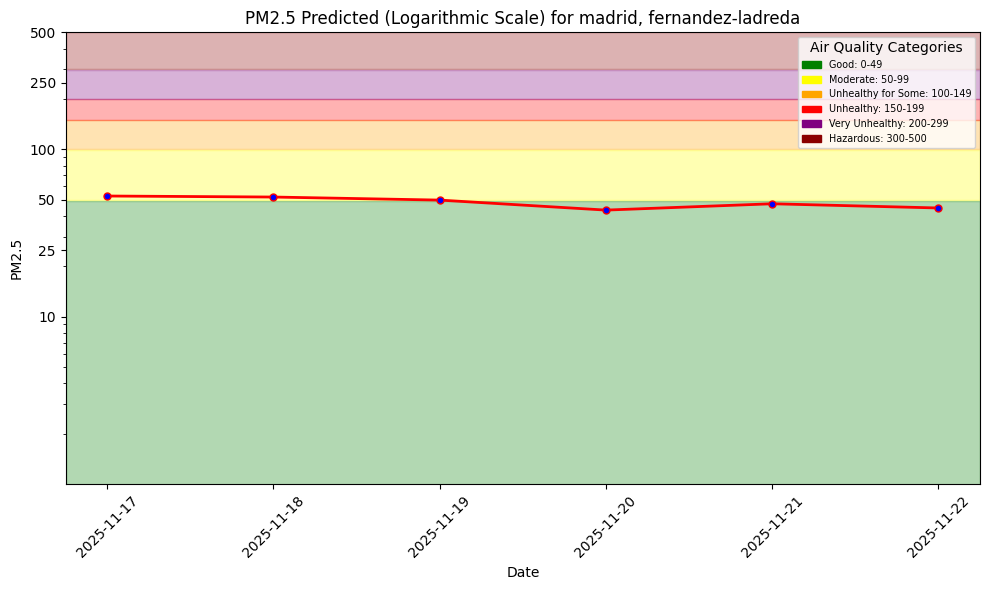

In [82]:
# Carpeta donde se van a guardar las imágenes
img_dir = f"{root_dir}/docs/air-quality/assets/img"
os.makedirs(img_dir, exist_ok=True)

# Recorremos cada sensor/calle
for sensor_id in batch_data['sensor_id'].unique():
    df_sensor = batch_data[batch_data['sensor_id'] == sensor_id].copy()
    df_sensor = df_sensor.sort_values('date')

    # nombre bonito de la calle (viene en la columna street)
    street_name = df_sensor['street'].iloc[0]
    city = df_sensor['city'].iloc[0]

    # archivo distinto por sensor
    pred_file_path = os.path.join(
        img_dir,
        f"pm25_forecast_{street_name}.png"   # ej: pm25_forecast_casa-de-campo.png
    )

    print(f"Generando gráfica para {street_name} → {pred_file_path}")

    plt = util_2.plot_air_quality_forecast(
        city,
        street_name,
        df_sensor,
        pred_file_path
    )
    plt.show()


In [83]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [84]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 42/42 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271984/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-16 22:33:03,092 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 22:33:06,272 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 22:34:48,197 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 22:34:48,359 INFO: Waiting for log aggregation to finish.
2025-11-16 22:35:10,320 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [85]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.19s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,cloud_cover_max,relative_humidity_2m_mean,dew_point_2m_max,city,sensor_id,country,street,predicted_pm25,days_before_forecast_day
0,2025-11-17 00:00:00+00:00,12.65,0.0,5.351785,42.273628,48.0,69.0,7.109425,madrid,mendez_alvaro,spain,mendez-alvaro,52.258221,1
1,2025-11-17 00:00:00+00:00,12.00,0.0,5.351785,42.273628,48.0,69.0,6.487256,madrid,cuatro_caminos,spain,cuatro-caminos,52.808750,1
2,2025-11-17 00:00:00+00:00,11.70,0.0,5.351785,42.273628,48.0,69.0,6.200077,madrid,plaza_castilla,spain,plaza-de-castilla,52.808750,1
3,2025-11-17 00:00:00+00:00,12.35,0.0,5.351785,42.273628,48.0,69.0,6.822279,madrid,casa_de_campo,spain,casa-de-campo,52.607952,1
4,2025-11-17 00:00:00+00:00,12.05,0.0,5.351785,42.273628,48.0,69.0,6.535117,madrid,castellana,spain,castellana,52.607952,1
5,2025-11-17 00:00:00+00:00,12.05,0.0,5.351785,42.273628,48.0,69.0,6.535117,madrid,escuelas_aguirre,spain,escuelas-aguirre,52.607952,1
6,2025-11-17 00:00:00+00:00,12.45,0.0,5.351785,42.273628,48.0,69.0,6.917996,madrid,fernandez_ladreda,spain,fernandez-ladreda,52.607952,1


In [88]:
air_quality_fg = fs.get_feature_group(name='air_quality_madrid', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.11s) 


,date,pm25,sensor_id,city,country,street
0,2015-08-09 00:00:00+00:00,28.0,plaza_castilla,madrid,spain,plaza-de-castilla
1,2020-06-27 00:00:00+00:00,28.0,fernandez_ladreda,madrid,spain,fernandez-ladreda
2,2016-11-26 00:00:00+00:00,21.0,castellana,madrid,spain,castellana
3,2024-04-15 00:00:00+00:00,56.0,fernandez_ladreda,madrid,spain,fernandez-ladreda
4,2021-01-29 00:00:00+00:00,41.0,mendez_alvaro,madrid,spain,mendez-alvaro
...,...,...,...,...,...,...
27768,2025-11-16 00:00:00+00:00,17.0,escuelas_aguirre,madrid,spain,escuelas-aguirre
27769,2025-11-16 00:00:00+00:00,13.0,casa_de_campo,madrid,spain,casa-de-campo
27770,2025-11-16 00:00:00+00:00,5.0,mendez_alvaro,madrid,spain,mendez-alvaro
27771,2025-11-16 00:00:00+00:00,13.0,castellana,madrid,spain,castellana


In [87]:
from mlfs.airquality import util_2
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])
hindcast_df

,date,predicted_pm25,pm25


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

In [78]:
img_dir = f"{root_dir}/docs/air-quality/assets/img"
os.makedirs(img_dir, exist_ok=True)

# Graficar hindcast para cada sensor
for sensor_id in hindcast_df['sensor_id'].unique():
    df_sensor = hindcast_df[hindcast_df['sensor_id'] == sensor_id].copy()
    df_sensor = df_sensor.sort_values('date')

    street_name = df_sensor['street'].iloc[0]

    hindcast_file_path = os.path.join(
        img_dir,
        f"pm25_hindcast_1day_{street_name}.png"
    )

    print(f"Hindcast → {street_name} → {hindcast_file_path}")

    plt = util.plot_air_quality_forecast(
        city,
        street_name,
        df_sensor,
        hindcast_file_path,
        hindcast=True
    )
    plt.show()


KeyError: 'sensor_id'

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [19]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna/docs/air-quality/as…

Uploading /Users/davidbazalduamendez/Documents/GitHub/Air-Quality-Prediction-Service-Solna/docs/air-quality/as…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1271984/settings/fb/path/Resources/airquality


---